Requires notebook 5.

In [29]:
suppressPackageStartupMessages({
  library(data.table)
  library(dplyr)
  library(cowplot)
  library(magrittr)
  library(dataorganizer)
  library(pagoda2)
  library(ggrepel)

  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

ℹ Loading cellAdmixNotebooks


In [2]:
# load the precomputed marker genes
markers = DatasetPath("nsclc_rna", "nsclc_markers_list_full.tsv") %>%
  read.table(sep = '\t',header=TRUE)
tumor.marker.genes <- markers$Gene[markers$cluster=='malignant']
macro.marker.genes <- markers$Gene[markers$cluster=='macrophage']
fibroblast.marker.genes <- markers$Gene[markers$cluster=='fibroblast']

In [3]:
# load the counts version of the unclean/clean data generated in NSCLC_CRF_all_cells.ipynb
base_dir <- CachePath('nsclc_scaled_dat11/')

so_spat_orig <- readRDS(file=paste0(base_dir,'so_spatial_orig.rds'))
dat_orig <- so_spat_orig[['RNA']]$counts
meta_orig <- so_spat_orig@meta.data

k <- 15
so_spat_cln <- readRDS(file=paste0(base_dir,'so_spatial_cln_',k,'_fib_full.rds'))
dat_cln <- so_spat_cln[['RNA']]$counts
meta_cln <- so_spat_cln@meta.data

In [4]:
# appending region labels to the metadata
cell_annot <- prepare_nsclc_metadata(reps='all')
# cell_annot <- prepare_nsclc_metadata(reps='one')
meta_orig$niche <- cell_annot[rownames(meta_orig),'niche']
meta_cln$niche <- cell_annot[rownames(meta_cln),'niche']

In [5]:
subset_cell_ct_region <- function(dat,meta,cell_type) {
  # subset to just one cell type
  cells_keep <- rownames(meta)[meta$cell_type==cell_type]
  meta <- meta[cells_keep,]
  dat <- dat[,cells_keep]

  # add annotation for regions to compare with de
  meta$regions_compare <- sapply(meta$niche,function(x) {
    if (x=='tumor interior') {
      return('tumor')
    } else if (x=='stroma') {
      return('stroma')
    } else {
      return(NA)
    }
  })

  # reduce data to just the cells in the tested regions
  cells_keep <- rownames(meta)[!is.na(meta$regions_compare)]
  meta <- meta[cells_keep,]
  dat <- dat[,cells_keep]
  return(list(dat,meta))
}
orig_sub <- subset_cell_ct_region(dat_orig,meta_orig,cell_type='fibroblast')
dat_orig <- orig_sub[[1]]
meta_orig <- orig_sub[[2]]

cln_sub <- subset_cell_ct_region(dat_cln,meta_cln,cell_type='fibroblast')
dat_cln <- cln_sub[[1]]
meta_cln <- cln_sub[[2]]

In [6]:
## run de for original counts
dat_pgda_orig <- basicP2proc(dat_orig, n.cores=1, min.cells.per.gene=0,
                            n.odgenes=2e3, get.largevis=FALSE, make.geneknn=FALSE)
regions_compare <- meta_orig$regions_compare
names(regions_compare) <- rownames(meta_orig)
de_out_orig <- dat_pgda_orig$getDifferentialGenes(verbose=TRUE,groups=regions_compare,z.threshold = 0,
                                            upregulated.only=FALSE,append.auc = TRUE)
de_out_orig <- de_out_orig[['tumor']]

16766 cells, 960 genes; normalizing ... 

Using plain model 

Winsorizing ... 

log scale ... 

done.


calculating variance fit ...

 using gam 

49 overdispersed genes ... 49

persisting ... 

done.

running PCA using 960 OD genes .

.



.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


running tSNE using 1 cores:


running differential expression with 2 clusters ... 

adjusting p-values ... 

done.




Warning message:
“Removed 953 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


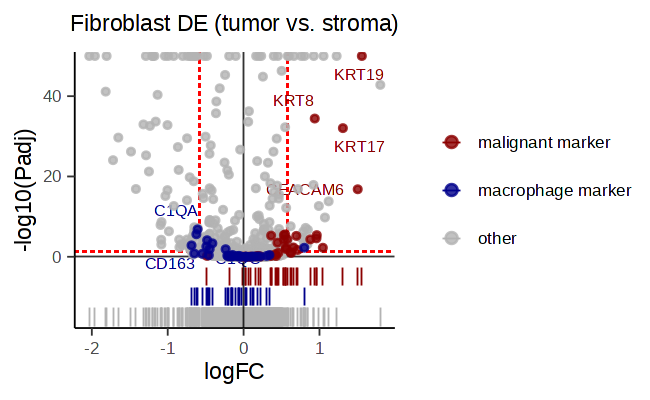

In [7]:
options(repr.plot.width = 3.25, repr.plot.height = 2, repr.plot.res = 200)

## making volcano plot for original DE
de_out_orig$padj <- 2*pnorm(abs(de_out_orig$Z), mean = 0, sd = 1, lower.tail = FALSE) # convert z back to padj
de_out_orig$mark_other <- sapply(de_out_orig$Gene,function(x){
  if (x %in% tumor.marker.genes) {
    return('malignant marker')
  } else if (x %in% macro.marker.genes) {
    return('macrophage marker')
  } else {
    return('other')
  }
})
de_out_orig$logpv <- -log10(de_out_orig$padj)
genes_to_label <- c('KRT19','KRT8','KRT17','CEACAM6','CD163','C1QA','C1QC')
ndx_lab <- which(de_out_orig$Gene %in% genes_to_label)
de_out_orig$top_mark_other <- NA
de_out_orig[ndx_lab,'top_mark_other'] <- de_out_orig$Gene[ndx_lab]
de_out_orig$logpv[de_out_orig$logpv>50] <- 50
ymax <- max(de_out_orig$logpv,na.rm=TRUE) + 1
myColors <- c('red4','blue4','grey70')

# Helper variables
limits <- range(de_out_orig$logpv,na.rm = TRUE,finite = TRUE)
step   <- diff(limits) * 0.1
size   <- 0.45 * step

de_out_orig$mark_other <- factor(de_out_orig$mark_other,levels=c('malignant marker','macrophage marker','other'))
bottom_lim <- min(limits[1] - as.numeric(de_out_orig$mark_other) * step - size) - .5

p <- ggplot(de_out_orig,aes(x=M,y=logpv,color=mark_other,label=top_mark_other)) +
  geom_segment(aes(y=ymax,yend=0,x = log2(1.5)),color='red',linetype='dashed',alpha=gg_line_alpha,linewidth=3*gg_line_thickness/4) +
  geom_segment(aes(y=ymax,yend=0,x = -log2(1.5)),color='red',linetype='dashed',alpha=gg_line_alpha,linewidth=3*gg_line_thickness/4) +
  geom_hline(yintercept=0,linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_segment(aes(x=-Inf,xend=Inf,y = -log10(.05)),color='red',linetype='dashed',alpha=gg_line_alpha,linewidth=3*gg_line_thickness/4) +
  geom_segment(
    aes(
      color = mark_other,
      xend = M,
      y    = limits[1] - as.numeric(mark_other) * step + size,
      yend = limits[1] - as.numeric(mark_other) * step - size
    ),
      linewidth=gg_line_thickness
  ) +
  geom_text_repel(size=geom_text_size, family=font_choice, show.legend = FALSE) +
  geom_vline(xintercept=0,linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_point(data=de_out_orig[de_out_orig$mark_other=='other',],alpha=gg_point_alpha,size=gg_point_size) +
  geom_point(data=de_out_orig[de_out_orig$mark_other=='malignant marker',],alpha=gg_point_alpha,size=gg_point_size) +
  geom_point(data=de_out_orig[de_out_orig$mark_other=='macrophage marker',],alpha=gg_point_alpha,size=gg_point_size) +
  scale_y_continuous(limits=c(bottom_lim,ymax),expand = c(0, 0)) +
  xlab('logFC') +
  ylab('-log10(Padj)') +
  ggtitle('Fibroblast DE (tumor vs. stroma)') +
  scale_colour_manual(breaks = c('malignant marker','macrophage marker','other'), values = myColors) +
  theme_classic(base_line_size = gg_line_thickness) +
  p_theme +
  theme(plot.title = element_text(hjust = 0.5),
       legend.title=element_blank()) +
  legend_mod

p


In [9]:
## run fgsea

# first loading up the marker de results to subset genes to the intersection with these
marker_de_out <- DatasetPath("nsclc_rna", "markers.csv") %>% read.csv()

## need to limit the genes to only those tested for scRNA cluster DE
de_out_orig_sub <- de_out_orig[de_out_orig$Gene %in% marker_de_out$Gene,]
dim(de_out_orig)
dim(de_out_orig_sub)

mystats <- de_out_orig$M
names(mystats) <- rownames(de_out_orig)
set_list <- list(tumor.marker.genes,macro.marker.genes)
names(set_list) <- c('tumor_markers','macro_markers')
fgsea_res <- fgsea::fgseaSimple(pathways = set_list,
                              stats = mystats,
                              minSize=5,
                              nperm=10000)
print(head(fgsea_res))

[1] 960  13

[1] 958  13

         pathway         pval         padj         ES       NES nMoreExtreme
          <char>        <num>        <num>      <num>     <num>        <num>
1: tumor_markers 0.0002805049 0.0005610098  0.8362722  2.797455            0
2: macro_markers 0.0877165600 0.0877165600 -0.4614082 -1.359264          561
    size  leadingEdge
   <int>       <list>
1:    36 KRT19, C....
2:    33 CD163, C....


In [10]:
# seeing how many of the top significant genes are tumor markers
head(de_out_orig_sub)
de_out_orig_sub_sig <- de_out_orig_sub[de_out_orig_sub$padj<.05 & de_out_orig_sub$M>log2(1.5),]
sum(de_out_orig_sub_sig$mark_other=='malignant marker')
nrow(de_out_orig_sub_sig)

,Z,M,highest,fe,Gene,AUC,Specificity,Precision,ExpressionFraction,padj,mark_other,logpv,top_mark_other
,<dbl>,<dbl>,<lgl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<chr>
IGFBP5,37.74133,1.0533639,TRUE,0.7529412,IGFBP5,0.6965387,0.6542674,0.2571388,0.7529412,0.000000e+00,other,50,NA
COL4A2,33.86125,0.6635246,TRUE,0.8226891,COL4A2,0.6231477,0.4400324,0.1910244,0.8226891,2.479115e-251,other,50,NA
ITGA1,27.21755,0.8024851,TRUE,0.6491597,ITGA1,0.6271309,0.6267657,0.2138112,0.6491597,4.026379e-163,other,50,NA
COL4A1,26.41008,0.7601104,TRUE,0.6626050,COL4A1,0.6267286,0.6124827,0.2113091,0.6626050,1.049460e-153,other,50,NA
CALD1,25.28378,0.5971087,TRUE,0.7130252,CALD1,0.6029327,0.5158272,0.1887023,0.7130252,4.817709e-141,other,50,NA
COL9A2,23.51937,0.2319313,TRUE,0.9470588,COL9A2,0.5254201,0.1115628,0.1488083,0.9470588,2.584793e-122,other,50,NA


[1] 11

[1] 36

In [11]:
pdf(OutputPath("nsclc_fibroblast_de.pdf"), useDingbats=FALSE, width=3.25, height=2)
p
dev.off()

Warning message:
“Removed 953 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


png 
  2

In [12]:
## run de for cleaned data
dat_pgda_cln <- basicP2proc(dat_cln, n.cores=1, min.cells.per.gene=0,
                        n.odgenes=2e3, get.largevis=FALSE, make.geneknn=FALSE)
regions_compare <- meta_cln$regions_compare
names(regions_compare) <- rownames(meta_cln)
de_out_cln <- dat_pgda_cln$getDifferentialGenes(verbose=TRUE,groups=regions_compare,z.threshold = 0,
                                        upregulated.only=FALSE,append.auc = TRUE)
de_out_cln <- de_out_cln[['tumor']]

# order genes the same in both de results matrixes
de_out_orig <- de_out_orig[rownames(de_out_cln),]

16093 cells, 960 genes; normalizing ... 

Using plain model 

Winsorizing ... 

log scale ... 

done.


calculating variance fit ...

 using gam 

35 overdispersed genes ... 35

persisting ... 

done.



running PCA using 960 OD genes .

.

.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


running tSNE using 1 cores:


running differential expression with 2 clusters ... 

adjusting p-values ... 

done.




Warning message:
“Removed 953 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


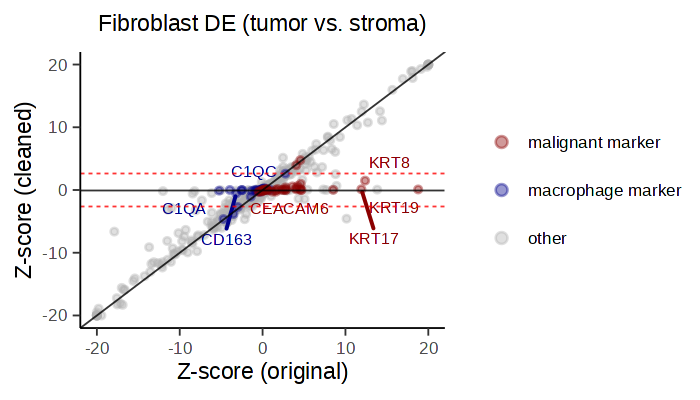

In [13]:
options(repr.plot.width = 3.5, repr.plot.height = 2, repr.plot.res = 200)

#### plot DE comparison
z_thresh <- qnorm(.01/2,lower.tail = FALSE)
tmp <- cbind.data.frame(de_out_orig[,'Z'],de_out_cln[,'Z'])
colnames(tmp) <- c('orig','clean')
rownames(tmp) <- rownames(de_out_orig)

## trying to color points by tumor marker set belonging
tmp$markers <- sapply(rownames(tmp),function(x){
  if (x %in% tumor.marker.genes) {
    return('malignant marker')
  } else if (x %in% macro.marker.genes) {
    return('macrophage marker')
  } else {
    return('other')
  }
})
genes_to_label <- c('KRT19','KRT8','KRT17','CEACAM6','CD163','C1QA','C1QC')
ndx_lab <- match(genes_to_label,rownames(tmp))
genes_to_label <- genes_to_label[!is.na(ndx_lab)]
ndx_lab <- ndx_lab[!is.na(ndx_lab)]
tmp$glab <- NA
tmp[ndx_lab,'glab'] <- genes_to_label
z_upper_thresh <- 20
tmp[which(tmp$orig>z_upper_thresh),'orig'] <- z_upper_thresh
tmp[which(tmp$orig<(-z_upper_thresh)),'orig'] <- -z_upper_thresh
tmp[which(tmp$clean>z_upper_thresh),'clean'] <- z_upper_thresh
tmp[which(tmp$clean<(-z_upper_thresh)),'clean'] <- -z_upper_thresh
tmp$markers <- factor(tmp$markers,levels=c('macrophage marker','other','malignant marker'))
myColors <- c('red4','blue4','grey70')
p <- ggplot(tmp,aes(x=orig,y=clean,color=markers,label=glab)) +
  geom_point(data=tmp[tmp$markers=='other',],alpha=gg_point_alpha/2,size=gg_point_size) +
  geom_point(data=tmp[tmp$markers=='macrophage marker',],alpha=gg_point_alpha/2,size=gg_point_size) +
  geom_point(data=tmp[tmp$markers=='malignant marker',],alpha=gg_point_alpha/2,size=gg_point_size) +
  geom_text_repel(size=geom_text_size, family=font_choice, show.legend = FALSE) +
  ggtitle('Fibroblast DE (tumor vs. stroma)') +
  xlab('Z-score (original)') +
  ylab('Z-score (cleaned)') +
  geom_hline(yintercept = z_thresh,color='red',linetype='dashed',linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_hline(yintercept = -1*z_thresh,color='red',linetype='dashed',linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_hline(yintercept = 0,linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_abline(slope = 1,intercept=0,linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  scale_colour_manual(breaks = c('malignant marker','macrophage marker','other'), values = myColors) +
  theme_classic(base_line_size = gg_line_thickness) +
  p_theme +
  theme(plot.title = element_text(hjust = 0.5),
       legend.title=element_blank()) +
  legend_mod

p

In [14]:
pdf(OutputPath("nsclc_de_compare.pdf"), useDingbats=FALSE, width=3.5, height=2)
p
dev.off()

Warning message:
“Removed 953 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


png 
  2

In [18]:
### now testing for enriched gene sets in both de results
m_df <- data.frame()
m_df <- rbind(m_df, msigdbr::msigdbr(species = "Homo sapiens",
                                    collection = "C5", subcollection = "BP"))
my_pathways <- split(m_df$gene_symbol, f = m_df$gs_name)

mystats <- abs(de_out_orig$Z)
# mystats <- de_out_orig$M
names(mystats) <- rownames(de_out_orig)
fgsea_res_orig <- fgsea::fgsea(pathways = my_pathways,
                               stats = mystats,
                               minSize=10,
                               maxSize=500,
                               eps=0,
                               gseaParam=0,
                               scoreType = "pos")
# fgsea_res_orig <- fgsea::fgsea(pathways = my_pathways,
#                                stats = mystats,
#                                minSize=10,
#                                maxSize=500,
#                                eps=0,
#                                gseaParam=0)
rownames(fgsea_res_orig) <- fgsea_res_orig$pathway

mystats <- abs(de_out_cln$Z)
# mystats <- de_out_cln$M
names(mystats) <- rownames(de_out_cln)
fgsea_res_clean <- fgsea::fgsea(pathways = my_pathways,
                                stats = mystats,
                                minSize=10,
                                maxSize=500,
                                eps=0,
                                gseaParam=0,
                                scoreType = "pos")
# fgsea_res_clean <- fgsea::fgsea(pathways = my_pathways,
#                                 stats = mystats,
#                                 minSize=10,
#                                 maxSize=500,
#                                 eps=0,
#                                 gseaParam=0)
rownames(fgsea_res_clean) <- fgsea_res_clean$pathway

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (27.92% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (44.79% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


Warning message:
“Removed 1884 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


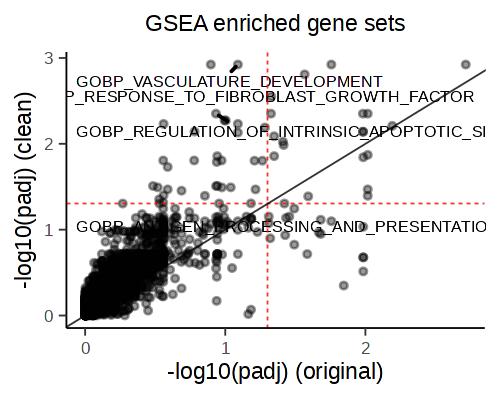

In [19]:
options(repr.plot.width = 2.5, repr.plot.height = 2, repr.plot.res = 200)

## plot GSEA comparison
tmp <- cbind.data.frame(-log10(fgsea_res_clean[,'padj']),-log10(fgsea_res_orig[,'padj']))
colnames(tmp) <- c('clean','orig')
upper_lim <- 3
tmp[tmp>upper_lim] <- upper_lim
tmp$pathway <- fgsea_res_clean$pathway
tmp$gslab <- NA
ndx_lab <- which(tmp$pathway %in% c('GOBP_VASCULATURE_DEVELOPMENT',
                                   'GOBP_REGULATION_OF_INTRINSIC_APOPTOTIC_SIGNALING_PATHWAY',
                                   'GOBP_RESPONSE_TO_FIBROBLAST_GROWTH_FACTOR',
                                   'GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION'))
tmp$gslab[ndx_lab] <- fgsea_res_clean$pathway[ndx_lab]
p <- ggplot(tmp,aes(x=orig,y=clean,label=gslab)) +
  geom_point(alpha=gg_point_alpha/2,size=gg_point_size) +
  geom_text_repel(size=geom_text_size,show.legend = FALSE,family=font_choice,min.segment.length = 0) +
  geom_vline(xintercept=-log10(.05),color='red',linetype='dashed',linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_hline(yintercept=-log10(.05),color='red',linetype='dashed',linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_abline(slope = 1,intercept=0,linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  xlab('-log10(padj) (original)') +
  ylab('-log10(padj) (clean)') +
  ggtitle('GSEA enriched gene sets') +
  theme_classic(base_line_size = gg_line_thickness) +
  p_theme +
  theme(plot.title = element_text(hjust = 0.5),
       legend.title=element_blank()) +
  legend_mod

p

In [20]:
tmp[order(tmp$orig,decreasing=TRUE)[1:20],]

,clean,orig,pathway,gslab
,<dbl>,<dbl>,<chr>,<chr>
1801,2.9232830,2.716161,GOBP_SUPRAMOLECULAR_FIBER_ORGANIZATION,NA
397,2.2089172,2.191936,GOBP_EXTERNAL_ENCAPSULATING_STRUCTURE_ORGANIZATION,NA
229,1.3946850,2.016585,GOBP_CELL_MATRIX_ADHESION,NA
240,1.4691442,2.016585,GOBP_CELL_SUBSTRATE_ADHESION,NA
261,2.3511464,2.016585,GOBP_COLLAGEN_BIOSYNTHETIC_PROCESS,NA
264,1.8707588,2.016585,GOBP_COLLAGEN_METABOLIC_PROCESS,NA
47,1.0335700,1.984700,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION
49,0.6774029,1.984700,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EXOGENOUS_ANTIGEN,NA
50,0.6774029,1.984700,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EXOGENOUS_PEPTIDE_ANTIGEN,NA


In [21]:
pdf(OutputPath("nsclc_gsea_compare.pdf"), useDingbats = FALSE,
    width = 2.5, height = 2)
p
dev.off()

Warning message:
“Removed 1884 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


png 
  2

In [22]:
## getting gene set stats to make venn diagrams
z_thresh <- qnorm(.01/2,lower.tail = FALSE)
gs <- my_pathways[['GOBP_VASCULATURE_DEVELOPMENT']]
# gs <- my_pathways[['GOBP_POSITIVE_REGULATION_OF_LOCOMOTION']]
# gs <- my_pathways[['GOBP_REGULATION_OF_CELLULAR_COMPONENT_MOVEMENT']]
gs_in_data <- gs[gs %in% rownames(de_out_cln)]
sig_genes_cln <- rownames(de_out_cln)[abs(de_out_cln$Z)>z_thresh]
sig_genes_orig <- rownames(de_out_orig)[abs(de_out_orig$Z)>z_thresh]
gs_orig_intersect <- intersect(gs_in_data,sig_genes_orig)
gs_cln_intersect <- intersect(gs_in_data,sig_genes_cln)

# print(length(gs_in_data))
# print(length(sig_genes_cln))
# print(length(sig_genes_orig))
print(length(gs_orig_intersect))
print(length(gs_cln_intersect))

print(length(gs_in_data) - length(gs_orig_intersect))
print(length(sig_genes_orig) - length(gs_orig_intersect))

print(length(gs_in_data) - length(gs_cln_intersect))
print(length(sig_genes_cln) - length(gs_cln_intersect))

sum(gs_cln_intersect %in% gs_orig_intersect)/length(gs_cln_intersect)

[1] 57
[1] 53
[1] 133
[1] 172
[1] 137
[1] 122


[1] 0.9433962

In [23]:
options(repr.plot.width = 8, repr.plot.height = 2, repr.plot.res = 200)

# plot some marker genes with their before/after expression levels
get_mean_se <- function(x,s) {
  expr <- x[s,]
  expr_m <- mean(expr)
  expr_se <- sd(expr) / sqrt(length(expr))
  return(list(expr_m,expr_se))
}
# samp_marks <- sample(tumor.marker.genes,5)
samp_marks <- c('KRT19','KRT8','KRT17','CEACAM6')
tmp <- data.frame(matrix(ncol=5,nrow=0))
lib_sizes1 <- colSums(dat_orig)
dat_orig_norm <- sweep(dat_orig,2,lib_sizes1,'/')
lib_sizes2 <- colSums(dat_cln)
dat_cln_norm <- sweep(dat_cln,2,lib_sizes2,'/')
dat_orig_tumor <- dat_orig_norm[,meta_orig$regions_compare=='tumor']
dat_orig_stroma <- dat_orig_norm[,meta_orig$regions_compare=='stroma']
dat_cln_tumor <- dat_cln_norm[,meta_cln$regions_compare=='tumor']
dat_cln_stroma <- dat_cln_norm[,meta_cln$regions_compare=='stroma']
for (s in samp_marks) {
  res <- get_mean_se(dat_orig_tumor,s)
  tmp <- rbind.data.frame(tmp,c('orig',s,res[[1]],res[[2]],'tumor'))
  res <- get_mean_se(dat_orig_stroma,s)
  tmp <- rbind.data.frame(tmp,c('orig',s,res[[1]],res[[2]],'stroma'))
  res <- get_mean_se(dat_cln_tumor,s)
  tmp <- rbind.data.frame(tmp,c('cln',s,res[[1]],res[[2]],'tumor'))
  res <- get_mean_se(dat_cln_stroma,s)
  tmp <- rbind.data.frame(tmp,c('cln',s,res[[1]],res[[2]],'stroma'))
}
colnames(tmp) <- c('clean_status','gene','expr_mean','expr_se','region')
tmp$expr_mean <- as.numeric(tmp$expr_mean)
tmp$expr_se <- as.numeric(tmp$expr_se)

tmp_orig <- tmp[tmp$clean_status=='orig',]
ymax <- max(tmp$expr_mean)+max(tmp$expr_se)+.00005
p1 <- ggplot(tmp_orig,aes(x=gene,y=expr_mean,fill=region)) +
  geom_bar(stat='identity',position=position_dodge()) +
  geom_errorbar(aes(ymin = expr_mean - expr_se, ymax = expr_mean + expr_se),
                width = 0.5,
                position = position_dodge(width = 0.9)) +
  ylim(0,ymax) +
  ylab('Fraction expression') +
  ggtitle('Malignant marker expression\nin fibroblasts (original)') +
  theme_classic(base_line_size = gg_line_thickness) +
  theme(legend.position="none") +
  p_theme +
  theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1,size=5),
  text = element_text(family = font_choice),
  axis.text=element_text(size=5), axis.title=element_text(size=6),
  plot.title = element_text(hjust = 0.5, size = 6))

tmp_cln <- tmp[tmp$clean_status=='cln',]
p2 <- ggplot(tmp_cln,aes(x=gene,y=expr_mean,fill=region)) +
  geom_bar(stat='identity',position=position_dodge()) +
  geom_errorbar(aes(ymin = expr_mean - expr_se, ymax = expr_mean + expr_se),
                width = 0.5,
                position = position_dodge(width = 0.9)) +
  ylim(0,ymax) +
  ylab('Fraction expression') +
  theme_classic(base_line_size = gg_line_thickness) +
  ggtitle('Malignant marker expression\nin fibroblasts (clean)') +
  p_theme +
  theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1,size=5),
  text = element_text(family = font_choice),
  axis.text=element_text(size=5), axis.title=element_text(size=6),
  legend.text=element_text(size=6),
  legend.key.size = unit(6, 'pt'),
  legend.key.height = unit(6, 'pt'),
  legend.key.width = unit(6, 'pt'),
  legend.title=element_text(size=6),
  plot.title = element_text(hjust = 0.5, size = 6))




### doing same with the fibroblast markers
samp_marks <- sample(fibroblast.marker.genes,4)
tmp <- data.frame(matrix(ncol=5,nrow=0))
lib_sizes1 <- colSums(dat_orig)
dat_orig_norm <- sweep(dat_orig,2,lib_sizes1,'/')
lib_sizes2 <- colSums(dat_cln)
dat_cln_norm <- sweep(dat_cln,2,lib_sizes2,'/')
dat_orig_tumor <- dat_orig_norm[,meta_orig$regions_compare=='tumor']
dat_orig_stroma <- dat_orig_norm[,meta_orig$regions_compare=='stroma']
dat_cln_tumor <- dat_cln_norm[,meta_cln$regions_compare=='tumor']
dat_cln_stroma <- dat_cln_norm[,meta_cln$regions_compare=='stroma']
for (s in samp_marks) {
  res <- get_mean_se(dat_orig_tumor,s)
  tmp <- rbind.data.frame(tmp,c('orig',s,res[[1]],res[[2]],'tumor'))
  res <- get_mean_se(dat_orig_stroma,s)
  tmp <- rbind.data.frame(tmp,c('orig',s,res[[1]],res[[2]],'stroma'))
  res <- get_mean_se(dat_cln_tumor,s)
  tmp <- rbind.data.frame(tmp,c('cln',s,res[[1]],res[[2]],'tumor'))
  res <- get_mean_se(dat_cln_stroma,s)
  tmp <- rbind.data.frame(tmp,c('cln',s,res[[1]],res[[2]],'stroma'))
}

colnames(tmp) <- c('clean_status','gene','expr_mean','expr_se','region')
tmp$expr_mean <- as.numeric(tmp$expr_mean)
tmp$expr_se <- as.numeric(tmp$expr_se)

tmp_orig <- tmp[tmp$clean_status=='orig',]
ymax <- max(tmp$expr_mean)+max(tmp$expr_se)+.00005
p3 <- ggplot(tmp_orig,aes(x=gene,y=expr_mean,fill=region)) +
  geom_bar(stat='identity',position=position_dodge()) +
  geom_errorbar(aes(ymin = expr_mean - expr_se, ymax = expr_mean + expr_se),
                width = 0.5,
                position = position_dodge(width = 0.9)) +
  ylim(0,ymax) +
  ylab('Fraction expression') +
  ggtitle('Fibroblast marker expression\nin fibroblasts (original)') +
  theme_classic(base_line_size = gg_line_thickness) +
  theme(legend.position="none") +
  p_theme +
  theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1,size=5),
  text = element_text(family = font_choice),
  axis.text=element_text(size=5), axis.title=element_text(size=6),
  plot.title = element_text(hjust = 0.5, size = 6))

tmp_cln <- tmp[tmp$clean_status=='cln',]
p4 <- ggplot(tmp_cln,aes(x=gene,y=expr_mean,fill=region)) +
  geom_bar(stat='identity',position=position_dodge()) +
  geom_errorbar(aes(ymin = expr_mean - expr_se, ymax = expr_mean + expr_se),
                width = 0.5,
                position = position_dodge(width = 0.9)) +
  ylim(0,ymax) +
  ylab('Fraction expression') +
  ggtitle('Fibroblast marker expression\nin fibroblasts (clean)') +
  theme_classic(base_line_size = gg_line_thickness) +
  p_theme +
  theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1,size=5),
  text = element_text(family = font_choice),
  axis.text=element_text(size=5), axis.title=element_text(size=6),
  legend.text=element_text(size=6),
  legend.key.size = unit(6, 'pt'),
  legend.key.height = unit(6, 'pt'),
  legend.key.width = unit(6, 'pt'),
  legend.title=element_text(size=6),
  plot.title = element_text(hjust = 0.5, size = 6))

# p <- plot_grid(p1,p2,p3,p4,nrow=1,rel_widths = c(.75,1))

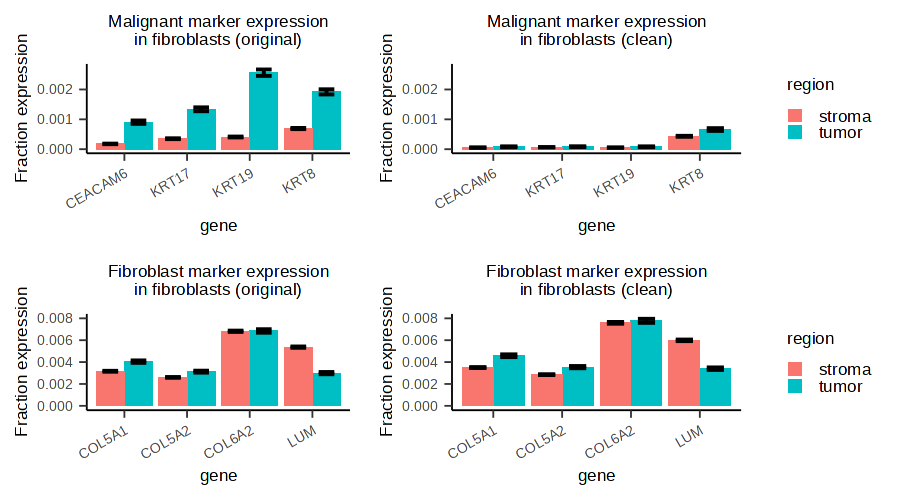

In [24]:
options(repr.plot.width = 4.5, repr.plot.height = 2.5, repr.plot.res = 200)

f1 <- plot_grid(p1,p2,nrow=1,rel_widths = c(.7,1.025))
f2 <- plot_grid(p3,p4,nrow=1,rel_widths = c(.7,1.025))

fig <- plot_grid(f1,f2,nrow=2)
fig

In [25]:
pdf(OutputPath("nsclc_example_genes_cleaned.pdf"), useDingbats=FALSE, width = 4.5, height = 2.5)
fig
dev.off()

png 
  2

In [26]:
### now running DE for macrophages by adjacency to fibroblasts
dat_orig <- so_spat_orig[['RNA']]$counts
meta_orig <- so_spat_orig@meta.data

so_spat_cln <- readRDS(file=paste0(base_dir,'so_spatial_cln_',k,'_macro_full.rds'))
dat_cln <- so_spat_cln[['RNA']]$counts
meta_cln <- so_spat_cln@meta.data

In [27]:
# appending region labels to the metadata
cell_annot <- prepare_nsclc_metadata(reps='all')
# cell_annot <- prepare_nsclc_metadata(reps='one')
meta_orig <- cbind.data.frame(meta_orig,cell_annot[rownames(meta_orig),c('niche','Run_Tissue_name','x','y')])
meta_cln <- cbind.data.frame(meta_cln,cell_annot[rownames(meta_cln),c('niche','Run_Tissue_name','x','y')])

In [30]:
# run knn separately for each slice of tissue
unq_z <- unique(meta_orig$Run_Tissue_name)

knn_ct_counts <- lapply(unq_z,function(z) {
    meta_sub <- meta_orig[meta_orig$Run_Tissue_name==z,]
    xn = meta_sub %>% select(x, y) %>% FNN::get.knn(k = 10) %>% .$nn.index
    ct_dict = meta_sub %>% mutate(id = 1:n()) %>% {setNames(.$cell_type, .$id)}
    cell_dict = meta_sub %>% mutate(id = 1:n()) %>% {setNames(.$cell, .$id)}
    nmat = apply(xn, 2, function(i){ct_dict[i]})

    ct_counts = nmat %>%
      reshape2::melt() %>%
      select(id = Var1, ct = value) %>%
      mutate(
        cell = cell_dict[id]
      ) %>%
      select(-id) %>%
      as.data.table %>%
      mutate(ct = paste0('n_', ct)) %>%
      count(cell, ct, .drop = T) %>%
      dcast(cell ~ ct, value.var = 'n', fill = 0)

    ct_counts <- as.data.frame(ct_counts)
    rownames(ct_counts) <- ct_counts$cell
    ct_counts$cell <- NULL

    return(ct_counts)
})
knn_ct_counts <- do.call(rbind.data.frame,knn_ct_counts)

In [31]:
head(knn_ct_counts)

,n_B-cell,n_NK,n_T CD4 memory,n_T CD4 naive,n_T CD8 memory,n_T CD8 naive,n_Treg,n_endothelial,n_epithelial,n_fibroblast,n_mDC,n_macrophage,n_malignant,n_mast,n_monocyte,n_neutrophil,n_pDC,n_plasmablast
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
c_1_10_1,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,7,0,0
c_1_10_10,0,0,0,0,0,0,0,1,0,2,0,0,4,1,0,0,0,2
c_1_10_100,0,0,0,0,0,0,0,1,3,0,0,0,0,3,0,3,0,0
c_1_10_1000,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0
c_1_10_1001,0,0,0,0,0,0,0,0,2,2,0,2,0,0,0,4,0,0
c_1_10_1002,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,4,0,0


In [32]:
## computing fraction of fibroblasts near each macrophage knn=10
fib_adj <- knn_ct_counts[,'n_fibroblast']/10
fib_adj <- unlist(fib_adj)
names(fib_adj) <- rownames(knn_ct_counts)
print(fib_adj[1:10])
print(min(fib_adj))
print(max(fib_adj))

   c_1_10_1   c_1_10_10  c_1_10_100 c_1_10_1000 c_1_10_1001 c_1_10_1002 
        0.0         0.2         0.0         0.0         0.2         0.0 
c_1_10_1003 c_1_10_1004 c_1_10_1005 c_1_10_1006 
        0.0         0.0         0.1         0.0 
[1] 0
[1] 1


In [33]:
## append adjacency scores to main metadata and substitute it to only the macrophages
meta_orig$fib_adj_fracs <- fib_adj[rownames(meta_orig)]
meta_orig$near_fib <- meta_orig$fib_adj_fracs > 0
meta_orig$near_fib <- factor(meta_orig$near_fib,levels=c(TRUE,FALSE))
levels(meta_orig$near_fib) <- c('Near','Not Near')

# subset to just macrophages
cells_keep <- rownames(meta_orig)[meta_orig$cell_type=='macrophage']
meta_orig <- meta_orig[cells_keep,]
dat_orig <- dat_orig[,cells_keep]

In [34]:
# now append the adjacency annotations for the cleaned version of the data
meta_cln$fib_adj_fracs <- fib_adj[rownames(meta_cln)]
meta_cln$near_fib <- meta_cln$fib_adj_fracs > 0
meta_cln$near_fib <- factor(meta_cln$near_fib,levels=c(TRUE,FALSE))
levels(meta_cln$near_fib) <- c('Near','Not Near')

In [35]:
# # running de for original data
dat_pgda_orig <- basicP2proc(dat_orig, n.cores=10, min.cells.per.gene=0,
                             n.odgenes=2e3, get.largevis=FALSE, make.geneknn=FALSE)
regions_compare <- meta_orig$near_fib
names(regions_compare) <- rownames(meta_orig)
de_out_orig <- dat_pgda_orig$getDifferentialGenes(verbose=TRUE,groups=regions_compare,z.threshold = 0,
                                                  upregulated.only=FALSE,append.auc = TRUE)
de_out_orig <- de_out_orig[['Near']]

17802 cells, 960 genes; normalizing ... 

Using plain model 

Winsorizing ... 

log scale ... 

done.


calculating variance fit ...

 using gam 

46 overdispersed genes ... 46

persisting ... 

done.

running PCA using 960 OD genes .

.



.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


running tSNE using 10 cores:


running differential expression with 2 clusters ... 

adjusting p-values ... 

done.




Warning message:
“Removed 955 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


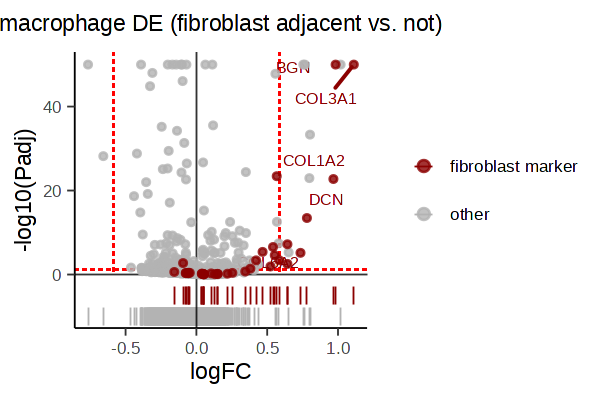

In [36]:
options(repr.plot.width = 3, repr.plot.height = 2, repr.plot.res = 200)

# ## making volcano plots
de_out_orig$padj <- 2*pnorm(abs(de_out_orig$Z), mean = 0, sd = 1, lower.tail = FALSE) # convert z back to padj
de_out_orig$mark_other <- sapply(de_out_orig$Gene,function(x){
  if (x %in% fibroblast.marker.genes) {
    return('fibroblast marker')
  } else {
    return('other')
  }
})
de_out_orig$logpv <- -log10(de_out_orig$padj)
genes_to_label <- c('BGN','COL3A1','COL1A2','DCN','COL6A2')
ndx_lab <- which(de_out_orig$Gene %in% genes_to_label)
de_out_orig$top_mark_other <- NA
de_out_orig[ndx_lab,'top_mark_other'] <- de_out_orig$Gene[ndx_lab]
de_out_orig$logpv[de_out_orig$logpv>50] <- 50
ymax <- max(de_out_orig$logpv,na.rm=TRUE)+3
myColors <- c('red4','grey70')

# Helper variables
limits <- range(de_out_orig$logpv,na.rm = TRUE,finite = TRUE)
step   <- diff(limits) * 0.1
size   <- 0.45 * step

de_out_orig$mark_other <- factor(de_out_orig$mark_other,levels=c('fibroblast marker','other'))
bottom_lim <- min(limits[1] - as.numeric(de_out_orig$mark_other) * step - size) - .5


p <- ggplot(de_out_orig,aes(x=M,y=logpv,color=mark_other,label=top_mark_other)) +
  geom_segment(aes(y=ymax,yend=0,x = log2(1.5)),color='red',linetype='dashed',alpha=gg_line_alpha,linewidth=3*gg_line_thickness/4) +
  geom_segment(aes(y=ymax,yend=0,x = -log2(1.5)),color='red',linetype='dashed',alpha=gg_line_alpha,linewidth=3*gg_line_thickness/4) +
  geom_hline(yintercept=0,linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_segment(aes(x=-Inf,xend=Inf,y = -log10(.05)),color='red',linetype='dashed',alpha=gg_line_alpha,linewidth=3*gg_line_thickness/4) +
  geom_segment(
    aes(
      color = mark_other,
      xend = M,
      y    = limits[1] - as.numeric(mark_other) * step + size,
      yend = limits[1] - as.numeric(mark_other) * step - size
    ),
      linewidth=gg_line_thickness
  ) +
  geom_text_repel(size=geom_text_size, family=font_choice, show.legend = FALSE) +
  geom_vline(xintercept=0,linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_point(data=de_out_orig[de_out_orig$mark_other=='other',],alpha=gg_point_alpha,size=gg_point_size) +
  geom_point(data=de_out_orig[de_out_orig$mark_other=='fibroblast marker',],alpha=gg_point_alpha,size=gg_point_size) +
  scale_y_continuous(limits=c(bottom_lim,ymax),expand = c(0, 0)) +
  xlab('logFC') +
  ylab('-log10(Padj)') +
  ggtitle('macrophage DE (fibroblast adjacent vs. not)') +
  scale_colour_manual(breaks = c('fibroblast marker','other'), values = myColors) +
  theme_classic(base_line_size = gg_line_thickness) +
  p_theme +
  theme(plot.title = element_text(hjust = 0.5),
       legend.title=element_blank()) +
  legend_mod

p

In [37]:
pdf(OutputPath("nsclc_macrophage_de.pdf"), useDingbats=FALSE, width = 3, height = 2)
p
dev.off()

Warning message:
“Removed 955 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


png 
  2

In [38]:
## run fgsea

# first loading up the marker de results to subset genes to the intersection with these
marker_de_out <- DatasetPath("nsclc_rna", "GSE127465", "markers.csv") %>% read.csv()

## need to limit the genes to only those tested for scRNA cluster DE
de_out_orig_sub <- de_out_orig[de_out_orig$Gene %in% marker_de_out$Gene,]

mystats <- de_out_orig$M
names(mystats) <- rownames(de_out_orig)
set_list <- list(fibroblast.marker.genes,macro.marker.genes)
names(set_list) <- c('fibroblast_markers','macro_markers')
fgsea_res <- fgsea::fgseaSimple(pathways = set_list,
                              stats = mystats,
                              minSize=5,
                              nperm=10000)
print(head(fgsea_res))

Warning message in file(file, "rt"):
“cannot open file '/home/vpetukhov/segmentation-error-impact/cellAdmix-Notebooks/../data/NSCLC/scRNAseq/GSE127465/GSE127465/markers.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [111]:
# now run de for cleaned version of the data
dat_pgda_cln <- basicP2proc(dat_cln, n.cores=10, min.cells.per.gene=0,
                            n.odgenes=2e3, get.largevis=FALSE, make.geneknn=FALSE)
regions_compare <- meta_cln$near_fib
names(regions_compare) <- rownames(meta_cln)
de_out_cln <- dat_pgda_cln$getDifferentialGenes(verbose=TRUE,groups=regions_compare,z.threshold = 0,
                                                upregulated.only=FALSE,append.auc = TRUE)
de_out_cln <- de_out_cln[['Near']]

# order genes the same in both de results matrixes
de_out_orig <- de_out_orig[rownames(de_out_cln),]

17307 cells, 960 genes; normalizing ... 

Using plain model 

Winsorizing ... 

log scale ... 

done.


calculating variance fit ...

 using gam 

34 overdispersed genes ... 34

persisting ... 

done.

running PCA using 960 OD genes .

.

.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


running tSNE using 10 cores:


running differential expression with 2 clusters ... 

adjusting p-values ... 

done.




Warning message:
“Removed 955 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


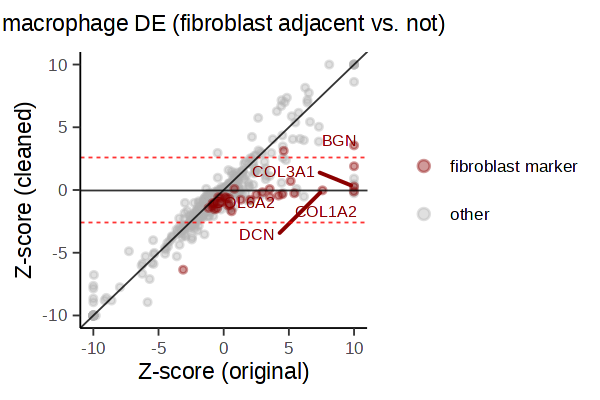

In [113]:
options(repr.plot.width = 3, repr.plot.height = 2, repr.plot.res = 200)

### getting a z threshold to mark on the plot
z_thresh <- qnorm(.01/2,lower.tail = FALSE)

# plot data
tmp <- cbind.data.frame(de_out_orig[,'Z'],de_out_cln[,'Z'])
colnames(tmp) <- c('orig','clean')
rownames(tmp) <- rownames(de_out_orig)

## trying to color points by tumor marker set belonging
tmp$markers <- sapply(rownames(tmp),function(x){
  if (x %in% fibroblast.marker.genes) {
    return('fibroblast marker')
  } else {
    return('other')
  }
})
genes_to_label <- c('BGN','COL3A1','COL1A2','DCN','COL6A2')
ndx_lab <- match(genes_to_label,rownames(tmp))
genes_to_label <- genes_to_label[!is.na(ndx_lab)]
ndx_lab <- ndx_lab[!is.na(ndx_lab)]
tmp$glab <- NA
tmp[ndx_lab,'glab'] <- genes_to_label
z_upper_thresh <- 10
tmp[which(tmp$orig>z_upper_thresh),'orig'] <- z_upper_thresh
tmp[which(tmp$orig<(-z_upper_thresh)),'orig'] <- -z_upper_thresh
tmp[which(tmp$clean>z_upper_thresh),'clean'] <- z_upper_thresh
tmp[which(tmp$clean<(-z_upper_thresh)),'clean'] <- -z_upper_thresh
tmp$markers <- factor(tmp$markers,levels=c('fibroblast marker','other'))
myColors <- c('red4','grey70')
p <- ggplot(tmp,aes(x=orig,y=clean,color=markers,label=glab)) +
  geom_point(data=tmp[tmp$markers=='other',],alpha=gg_point_alpha/2,size=gg_point_size) +
  geom_point(data=tmp[tmp$markers=='fibroblast marker',],alpha=gg_point_alpha/2,size=gg_point_size) +
  geom_text_repel(size=geom_text_size, family=font_choice, show.legend = FALSE) +
  ggtitle('macrophage DE (fibroblast adjacent vs. not)') +
  xlab('Z-score (original)') +
  ylab('Z-score (cleaned)') +
  geom_hline(yintercept = z_thresh,color='red',linetype='dashed',linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_hline(yintercept = -1*z_thresh,color='red',linetype='dashed',linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_hline(yintercept = 0,linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_abline(slope = 1,intercept=0,linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  scale_colour_manual(breaks = c('fibroblast marker','other'), values = myColors) +
  theme_classic(base_line_size = gg_line_thickness) +
  p_theme +
  theme(plot.title = element_text(hjust = 0.5),
       legend.title=element_blank()) +
  legend_mod

p

In [114]:
pdf(OutputPath("nsclc_de_compare_macro.pdf"), useDingbats=FALSE, width=3, height=2)
p
dev.off()

Warning message:
“Removed 955 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


png 
  2

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (16.98% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (44.79% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message:
“Removed 2136 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


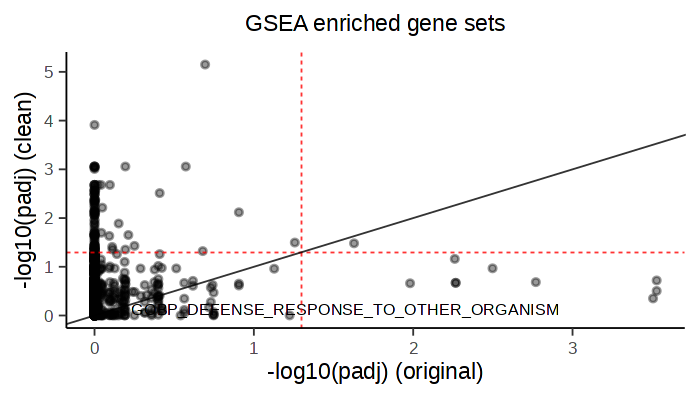

In [39]:
options(repr.plot.width = 3.5, repr.plot.height = 2, repr.plot.res = 200)

### now testing for enriched gene sets in both de results
m_df <- data.frame()
m_df <- rbind(m_df,msigdbr::msigdbr(species = "Homo sapiens",
                                    category = "C5", subcategory = "BP"))
# m_df <- rbind(m_df,msigdbr::msigdbr(species = "Homo sapiens",
#                                     category = "C2", subcategory = "KEGG"))
m_df <- rbind(m_df,msigdbr::msigdbr(species = "Homo sapiens",
                                    category = "C2", subcategory = "REACTOME"))
# m_df <- rbind(m_df,msigdbr::msigdbr(species = "Homo sapiens",
#                                     category = "C2", subcategory = "BIOCARTA"))
# m_df <- rbind(m_df,msigdbr::msigdbr(species = "Homo sapiens",
#                                     category = "H"))
my_pathways <- split(m_df$gene_symbol, f = m_df$gs_name)

mystats <- abs(de_out_orig$Z)
names(mystats) <- rownames(de_out_orig)
fgsea_res_orig <- fgsea::fgsea(pathways = my_pathways,
                               stats = mystats,
                               minSize=10,
                               maxSize=500,
                               eps=0,
                               gseaParam=0,
                               scoreType = "pos")
rownames(fgsea_res_orig) <- fgsea_res_orig$pathway


mystats <- abs(de_out_cln$Z)
names(mystats) <- rownames(de_out_cln)
fgsea_res_clean <- fgsea::fgsea(pathways = my_pathways,
                                stats = mystats,
                                minSize=10,
                                maxSize=500,
                                eps=0,
                                gseaParam=0,
                                scoreType = "pos")
rownames(fgsea_res_clean) <- fgsea_res_clean$pathway

tmp <- cbind.data.frame(-log10(fgsea_res_clean[,'padj']),-log10(fgsea_res_orig[,'padj']))
colnames(tmp) <- c('clean','orig')
tmp$pathway <- fgsea_res_clean$pathway
tmp$gslab <- NA
ndx_lab <- which(tmp$pathway %in% c('GOBP_INTERFERON_GAMMA_SIGNALING',
                                   'GOBP_DEFENSE_RESPONSE_TO_OTHER_ORGANISM'))
tmp$gslab[ndx_lab] <- fgsea_res_clean$pathway[ndx_lab]
p <- ggplot(tmp,aes(x=orig,y=clean,label=gslab)) +
  geom_point(alpha=gg_point_alpha/2,size=gg_point_size) +
  geom_text_repel(size=geom_text_size,show.legend = FALSE,family=font_choice) +
  geom_vline(xintercept=-log10(.05),color='red',linetype='dashed',linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_hline(yintercept=-log10(.05),color='red',linetype='dashed',linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_abline(slope = 1,intercept=0,linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  xlab('-log10(padj) (original)') +
  ylab('-log10(padj) (clean)') +
  ggtitle('GSEA enriched gene sets') +
  theme_classic(base_line_size = gg_line_thickness) +
  p_theme +
  theme(plot.title = element_text(hjust = 0.5),
       legend.title=element_blank()) +
  legend_mod

p

In [40]:
pdf(OutputPath("nsclc_gsea_compare_macro.pdf"), useDingbats=FALSE, width=3.5, height=2)
p
dev.off()

Warning message:
“Removed 2136 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


png 
  2